# Module 1. Predict Electricity Demand with GluonTS
---

본 핸즈온은 개별 가정용 전기 수요를 예측하는 여러 개의 모델들을 로컬 상에서 훈련하고, 사용자 정의 도커 컨테이너를 빌드 후 멀티모델 엔드포인트를 단일 호스팅 인스턴스에 배포하여 여러 모델들을 추론합니다. 아키텍처는 아래와 같으며, 실습 시간은 약 1시간을 권장합니다.

![01_arch_design_1](images/gluonts_sagemaker.png)

## 1. Introduction
---
지역 유틸리티는 가스 연소 발전기를 사용하여 피크 수요 시간에 추가 전기를 제공하고 추가 가스 전력 생산을 시작하려면 2시간의 리드 타임이 필요합니다. 또한, 모바일 앱을 통해 매일 예측되는 전기 사용량의 소비자에게 실시간 예측을 제공하고자 합니다. 이를 위한 모델링 요구 사항은 아래와 같습니다.
간단히 요약하면 아래와 같습니다.

- 전력 수요 데이터의 빈도는 2시간마다 변환합니다.
- 예측 모델은 미래 24시간의 전력 수요를 예측합니다. 2시간 단위로 예측하기 때문에 12개의 데이터 포인트를 예측합니다.
- 현재 비교할 대상이 없으므로 모델을 평가할 baseline 모델들이 필요합니다.

데이터셋은 [University of California Irvine Machine Learning Repository (UCI-MLR)](https://archive.ics.uci.edu/ml/datasets/Individual+household+electric+power+consumption)의 public repository 중 "Individual household electric power consumption" 셋을 사용합니다. 

<br>

## 2. Feature Engineering
---

In [1]:
from mxnet.context import num_gpus
from utils import *

downloading dataset (258MB), can take a few minutes depending on your connection
258 MB downloaded
extracting data archive


### 2.1. Read raw data

데이터를 로컬 볼륨에 다운로드했으므로 데이터를 메모리 내 Pandas 데이터프레임으로 로딩합니다. Pandas는 정형(tabular) 데이터 및 시계열(time-series) 데이터를 쉽게 처리하고 탐색할 수 있는 데이터 과학 라이브러리입니다. Pandas csv 함수를 사용하면 쿼리 결과를 메모리 내 데이터 프레임으로 직접 읽을 수 있습니다.

In [2]:
data = pd.read_csv(FILE_PATH, sep=";", index_col=0, parse_dates=True, decimal=',')

### 2.2. Basic Exploratory Data analysis
기본적인 통계치, 빈도 및 data range를 확인합니다.


In [3]:
data.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:30:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 00:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 01:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
data.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,...,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000
mean,3.970785,20.768480,2.918308,82.184490,37.240309,141.227385,4.521338,191.401476,39.975354,42.205152,...,218.213701,37607.987537,1887.427366,2940.031734,65.413150,9.269709,424.262904,94.704717,625.251734,8722.355145
std,5.983965,13.272415,11.014456,58.248392,26.461327,98.439984,6.485684,121.981187,29.814595,33.401251,...,204.833532,38691.954832,1801.486488,2732.251967,65.007818,10.016782,274.337122,80.297301,380.656042,9195.155777
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.844950,0.000000,36.585366,15.853659,71.428571,0.565291,111.111111,13.986014,9.677419,...,5.710207,0.000000,0.000000,0.000000,13.037810,0.000000,0.000000,30.050083,83.944282,0.000000
50%,1.269036,24.893314,1.737619,87.398374,39.024390,157.738095,2.826456,222.222222,40.209790,40.860215,...,131.334761,24100.000000,1050.632911,2136.363636,31.290743,7.021650,525.899912,76.794658,758.064516,0.000000
75%,2.538071,29.871977,1.737619,115.853659,54.878049,205.357143,4.522329,279.461279,57.692308,61.290323,...,403.283369,54800.000000,3312.236287,5363.636364,108.213820,11.702750,627.743635,151.919866,875.366569,17783.783784
max,48.223350,115.220484,151.172893,321.138211,150.000000,535.714286,44.657999,552.188552,157.342657,198.924731,...,852.962170,192800.000000,7751.054852,12386.363636,335.071708,60.269163,1138.718174,362.270451,1549.120235,30918.918919


In [5]:
data.index

DatetimeIndex(['2011-01-01 00:15:00', '2011-01-01 00:30:00',
               '2011-01-01 00:45:00', '2011-01-01 01:00:00',
               '2011-01-01 01:15:00', '2011-01-01 01:30:00',
               '2011-01-01 01:45:00', '2011-01-01 02:00:00',
               '2011-01-01 02:15:00', '2011-01-01 02:30:00',
               ...
               '2014-12-31 21:45:00', '2014-12-31 22:00:00',
               '2014-12-31 22:15:00', '2014-12-31 22:30:00',
               '2014-12-31 22:45:00', '2014-12-31 23:00:00',
               '2014-12-31 23:15:00', '2014-12-31 23:30:00',
               '2014-12-31 23:45:00', '2015-01-01 00:00:00'],
              dtype='datetime64[ns]', length=140256, freq=None)

In [6]:
data.index.min(), data.index.max()

(Timestamp('2011-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))

데이터는 2011-01-01부터 2015-01-01까지의 4년치 데이터이며 15분 간격으로 샘플링되고 있음을 알 수 있습니다.

### 2.3. Downsample to 2-hour samples by sum value

15분 단위 예측이 아니라 2시간 단위 예측이므로, 데이터를 2시간 빈도로 재샘플링합니다.

In [7]:
num_timeseries = data.shape[1]
data_kw = data.resample('2H').sum() / 8

In [8]:
data_kw.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,...,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-01 08:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


결측값 여부를 확인합니다. 본 데이터셋은 결측값이 없지만, 결측값이 있는 경우에는 imputation을 수행하는 것을 권장드립니다. 

In [9]:
data_kw.isna().sum().sum()

0

### 2.4. Visualization: Plot some sample time series

Pandas 데이터프레임을 아래 시계열 리스트로 변환합니다. 이 때, 각 시계열에서 0은 모두 삭제합니다.
> 본 핸즈온의 데이터는 0을 모두 삭제했지만, 일부 데이터셋에서는 0을 그대로 사용해야 할 수도 있습니다.

In [10]:
timeseries = []
for i in range(num_timeseries):
    timeseries.append(np.trim_zeros(data_kw.iloc[:,i], trim='f'))

matplotlib 라이브러리를 사용하여 아래와 같이 10개의 개별 시계열을 plotting합니다. 일부 시계열은 주기성이 보이지만, 일부 시계열은 불규칙한 패턴을 보입니다.

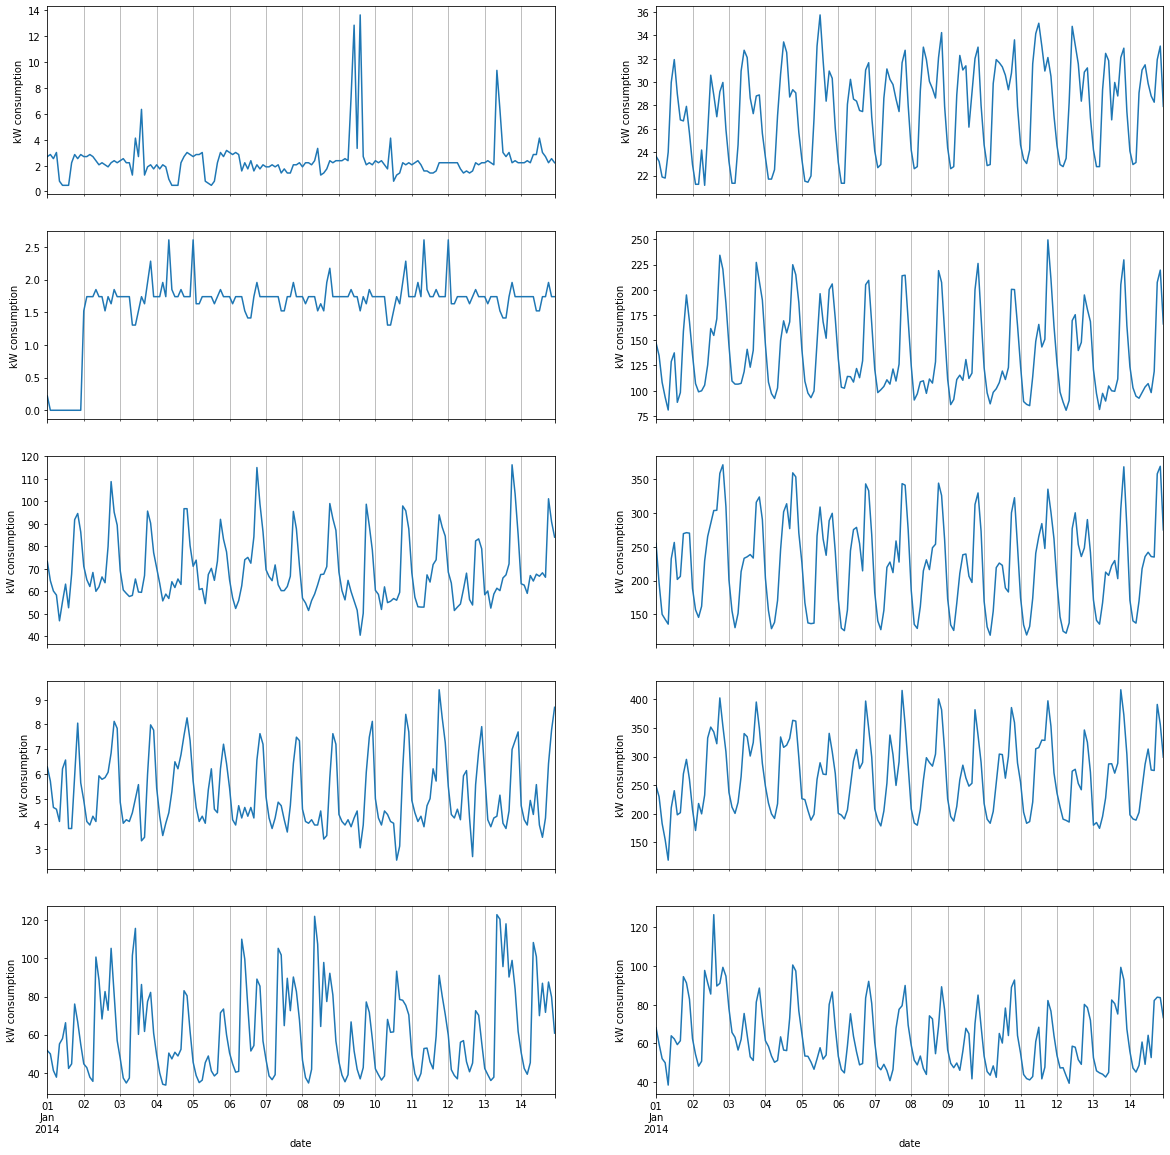

In [11]:
%matplotlib inline
fig, axs = plt.subplots(5, 2, figsize=(20, 20), sharex=True)
axx = axs.ravel()
for i in range(0, 10):
    timeseries[i].loc["2014-01-01":"2014-01-14"].plot(ax=axx[i])
    axx[i].set_xlabel("date")    
    axx[i].set_ylabel("kW consumption")   
    axx[i].grid(which='minor', axis='x')

### 2.5. Split data into training and a test sets

시계열 데이터를 훈련 데이터셋 및 테스트 데이터셋으로 분할합니다. 모델이 이전에 보지 못한 데이터에 대해 어떻게 수행되는지 정확하게 파악하려면 시계열 데이터를 컷오프 날짜에 따라 분할해야 합니다.

In [12]:
from gluonts.dataset.field_names import FieldName

In [13]:
training_data, test_data = split_train_test_data(timeseries[:n_timeseries],
                          start_training,
                          end_training,
                          num_test_windows)

### 2.6. Save data

향후 재사용을 위해 훈련 및 테스트 데이터를 로컬 및 S3에 저장합니다.

In [14]:
write_dicts_to_file(os.path.join(output_dir, 'train.json'), training_data)
upload_to_s3(bucket, prefix, os.path.join(output_dir, 'train.json'))
write_dicts_to_file(os.path.join(output_dir, 'test.json'), test_data)
upload_to_s3(bucket, prefix, os.path.join(output_dir, 'test.json'))

<br>

## 3.  Training and Evaluation
---

총 5종류의 모델을 훈련하고 테스트 데이터셋에 대한 예측을 수행 후, 훈련된 모델을 로컬 디스크에 저장합니다.
참고로, `train_and_test` 함수는 `utils.py`에 정의되어 있습니다.

### Mean

예측값으로 훈련 데이터의 평균을 사용하는 단순한 모델로 별도의 훈련이 필요하지 않습니다. 자세한 내용은 아래 링크를 참조하세요.
- https://ts.gluon.ai/api/gluonts/gluonts.model.trivial.mean.html

In [15]:
%%time
mean = MeanPredictor(freq=freq, 
                     prediction_length=prediction_length,
                     context_length=context_length)
forecasts_mean, tss_mean = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               mean,
               require_train=False)

CPU times: user 91.1 ms, sys: 275 µs, total: 91.4 ms
Wall time: 90.4 ms


### Seasonal Naive

과거 시계열 데이터를 그대로 복사하기에 별도의 훈련이 필요하지 않지만, 주기성이 강한 시계열에서 잘 동작합니다. 자세한 내용은 아래 링크를 참조하세요.
- https://ts.gluon.ai/api/gluonts/gluonts.model.seasonal_naive.html

In [16]:
%%time
seasonal = SeasonalNaivePredictor(freq=freq,
                                  prediction_length=prediction_length,
                                  season_length=prediction_length)
forecasts_seasonal, tss_seasonal = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               seasonal,
               require_train=False)

CPU times: user 55 ms, sys: 333 µs, total: 55.4 ms
Wall time: 54.1 ms


### Simple FeedForward Estimator

기본적인 MLP(Multi-Layer Perceptron)로 스칼라(1차원) 시계열을 예측합니다. 자세한 내용은 아래 링크를 참조하세요.
- https://ts.gluon.ai/api/gluonts/gluonts.model.simple_feedforward.html

In [17]:
device = 'gpu' if num_gpus() > 0 else "cpu"
trainer = Trainer(
    ctx=device,
    epochs=10,
    learning_rate=0.0005,
    num_batches_per_epoch=50
)
ffn = SimpleFeedForwardEstimator(
    num_hidden_dimensions=[50],
    prediction_length=prediction_length,
    context_length=2*prediction_length,
    freq=freq,
    trainer=trainer
)
forecasts_ffn, tss_ffn = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               ffn,
               require_train=True)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:00<00:00, 112.62it/s, epoch=10/10, avg_epoch_loss=3.9]


### Prophet

Prophet은 비선형 추세가 연도별, 주별, 일별 계절성과 공휴일 패턴에 적합한 additive 모델을 기반으로 시계열 데이터를 예측하는 알고리즘입니다. 계절성 효과가 강하고 여러 시즌의 데이터가 있는 시계열에서 잘 작동하며, 누락된 데이터와 추세의 변화에 강건합니다. 자세한 내용은 아래 링크를 참조하세요.
- https://ts.gluon.ai/api/gluonts/gluonts.model.prophet.html

In [18]:
!pip install -qU lunarcalendar fbprophet

In [19]:
%%time
prophet = ProphetPredictor(freq, prediction_length)
forecasts_prophet, tss_prophet = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               prophet,
               require_train=False
               )

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with ye

CPU times: user 34 s, sys: 366 ms, total: 34.3 s
Wall time: 34.2 s


### DeepAR

DeepAR은 RNN(Recurrent Neural Network) 기반 네트워크로 관련 시계열(related time-series)과 아이템 메타데이터를 같이 사용하여 스칼라(1차원) 시계열을 예측합니다. 자세한 내용은 아래 링크를 참조하세요.
- https://ts.gluon.ai/api/gluonts/gluonts.model.deepar.html
- Paper: https://arxiv.org/abs/1704.04110

In [20]:
%%time

trainer = Trainer(
    ctx=device,
    epochs=10,
    learning_rate=1e-4
)

deepar = DeepAREstimator(freq=freq,
                         use_feat_static_cat=True,
                         cardinality=[n_timeseries],
                         prediction_length=prediction_length,
                         distr_output=StudentTOutput(),
                         trainer=trainer,
                         num_cells=40)

forecasts_deepar, tss_deepar = train_and_test(training_data, 
               test_data,
               freq,
               num_test_windows,
               deepar,
               require_train=True)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:01<00:00, 33.14it/s, epoch=10/10, avg_epoch_loss=3.73]


CPU times: user 23 s, sys: 708 ms, total: 23.7 s
Wall time: 21.1 s


## 4. Results

모델의 성능을 평가하기 위해 `MAPE(Mean Absolute Percentage Error), RMSE(Root Mean Square Error), wQuantileLoss[0.5]`의 평가 지표들을 사용합니다.

### Performance Comparision
각 모델에 대한 평가 메트릭을 계산합니다.

In [21]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_mean, item_metrics_mean = evaluator(iter(tss_mean), 
                                                iter(forecasts_mean), 
                                                num_series=len(forecasts_mean))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 292.26it/s]


In [22]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_seasonal, item_metrics_seasonal = evaluator(iter(tss_seasonal), 
                                                        iter(forecasts_seasonal), 
                                                        num_series=len(forecasts_seasonal))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 291.38it/s]


In [23]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_prophet, item_metrics_prophet = evaluator(iter(tss_prophet), 
                                                      iter(forecasts_prophet), 
                                                      num_series=len(forecasts_prophet))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 291.37it/s]


In [24]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_ffn, item_metrics_ffn = evaluator(iter(tss_ffn), 
                                              iter(forecasts_ffn), 
                                              num_series=len(forecasts_ffn))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 289.20it/s]


In [25]:
evaluator = Evaluator(quantiles=[0.5], seasonality=None)
agg_metrics_deepar, item_metrics_deepar = evaluator(iter(tss_deepar), 
                                                    iter(forecasts_deepar), 
                                                    num_series=len(forecasts_deepar))

Running evaluation: 100%|██████████| 100/100 [00:00<00:00, 296.97it/s]


In [26]:
df_metrics = pd.concat([
    pd.DataFrame.from_dict(agg_metrics_mean, orient='index').rename(columns={0: "Mean"}),
    pd.DataFrame.from_dict(agg_metrics_seasonal, orient='index').rename(columns={0: "Seasonal naive"}),
    pd.DataFrame.from_dict(agg_metrics_prophet, orient='index').rename(columns={0: "Prophet"}),
    pd.DataFrame.from_dict(agg_metrics_ffn, orient='index').rename(columns={0: "SimpleFFN"}),       
    pd.DataFrame.from_dict(agg_metrics_deepar, orient='index').rename(columns={0: "DeepAR"})], axis=1)
df_metrics.loc[["MAPE", "RMSE", "wQuantileLoss[0.5]"]]

,Mean,Seasonal naive,Prophet,SimpleFFN,DeepAR
MAPE,0.321909,0.090301,0.118676,0.098522,0.115563
RMSE,103.638603,29.184250,27.856994,30.651281,24.498549
wQuantileLoss[0.5],0.271800,0.073931,0.075703,0.075118,0.072305


### Visualization: Plot Example Forecast

예측값과 실제값과의 차이를 확인합니다.

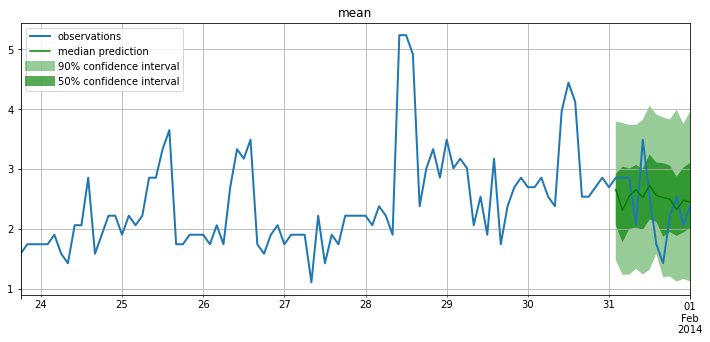

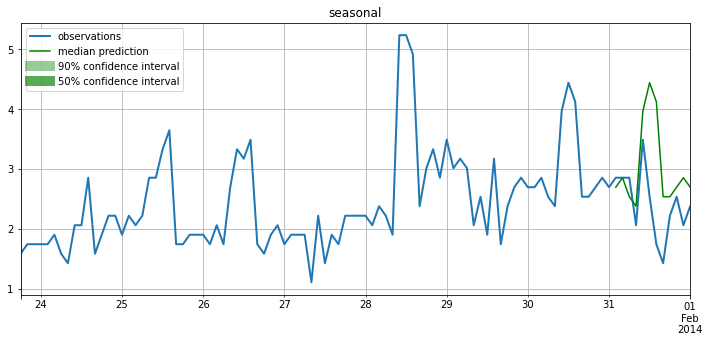

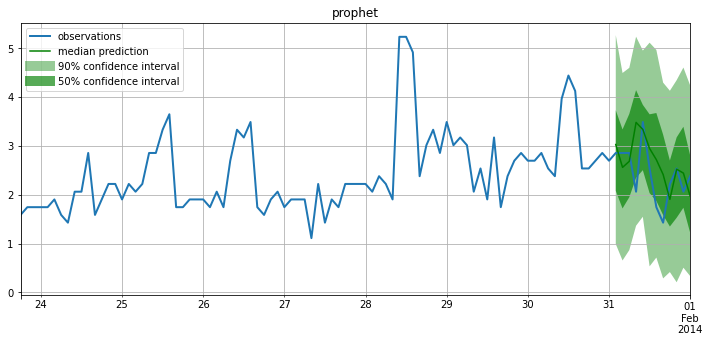

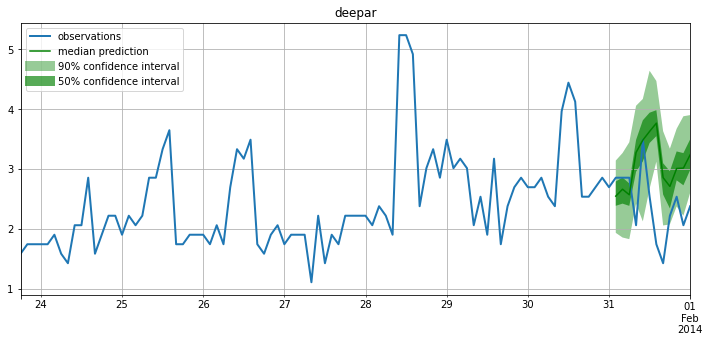

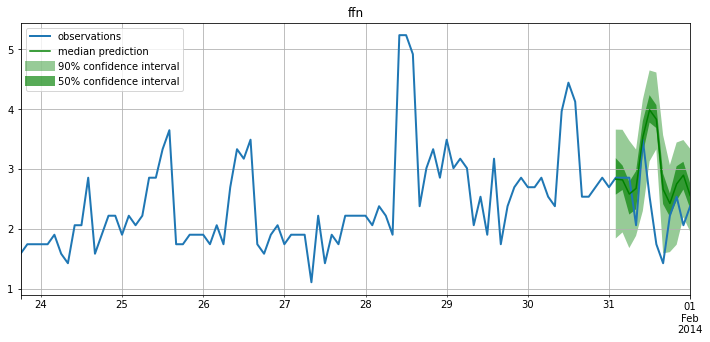

In [27]:
start, stop, step = 0, 1, 1
plot_forecasts(tss_mean, forecasts_mean, past_length=100, start=start, stop=stop, step=step, title="mean")
plot_forecasts(tss_seasonal, forecasts_seasonal, past_length=100, start=start, stop=stop, step=step, title="seasonal")
plot_forecasts(tss_prophet, forecasts_prophet, past_length=100, start=start, stop=stop, step=step, title="prophet")
plot_forecasts(tss_deepar, forecasts_deepar, past_length=100, start=start, stop=stop, step=step, title="deepar")
plot_forecasts(tss_ffn, forecasts_ffn, past_length=100, start=start, stop=stop, step=step, title="ffn")

<br>

## 5. Prepare the Model Artifacts for Deployment
---
### Upload model artifacts to S3

훈련된 모델을 SageMaker 엔드포인트에 배포하기 위해, 모델을 `.tar.gz` 형식으로 압축합니다. 

In [28]:
model_list = [
    "MeanPredictor",
    "SeasonalNaivePredictor",
    "ProphetPredictor",
    "SimpleFeedForwardEstimator",    
    "DeepAREstimator"
]
for model in model_list:
    with tarfile.open(models_dir + '/' + model +'.tar.gz', 'w:gz') as tar:
        tar.add(models_dir + '/' + model, arcname='.')

`tar.gz` 파일들을 S3에 업로드합니다.

In [29]:
for model in model_list:
    key = os.path.join(prefix, models_dir + '/' + model + '.tar.gz')
    with open(models_dir + '/' + model +'.tar.gz', 'rb') as file_obj:
        s3.Bucket(bucket).Object(key).upload_fileobj(file_obj)


수고하셨습니다. [다음 주피터 노트북](2.deployment_byoc_multi_model_endpoints.ipynb)을 계속 진행해 주세요.